In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform)

In [4]:
#2-layer encoder-decoder with relu activation
class Encoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, interm_size)
        self.fc2 = nn.Linear(interm_size, latent_size)
        self.act = act
    
    def forward(self, x):
        interm = self.act(self.fc1(x))
        latent = self.act(self.fc2(interm))
        return latent
    
class Decoder(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, act=torch.relu):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, interm_size)
        self.fc2 = nn.Linear(interm_size, 28*28)
        self.act = act
    
    def forward(self, x):
        interm = self.act( self.fc1(x) )
        output = torch.tanh( self.fc2(interm) ) 
        return output

In [5]:
class Net(nn.Module):
    def __init__(self, interm_size=32, latent_size=32, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.E = Encoder(interm_size, latent_size)
        self.D = Decoder(interm_size, latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [6]:
#models = {'16-16': Net(16,16), '32-32': Net(32,32), '64-64': Net(64,64), '128-64': Net(128,64)}
models = {'16-16': Net(16,16), '32-32': Net(32,32), '64-64': Net(64,64)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [25]:
def add_noise(x, mode='crop', elementwise=False, skip_one_half = False):
    
    gaus_mean = 0.0
    gaus_sigma = 1.5
    
    if skip_one_half and np.random.randint(2):
        return x
    x = x.clone()
    if elementwise:
        for i in range(x.shape[0]):
            if mode == 'crop':
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2)*2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
            elif mode == 'mirror_full_image':
                x[i] = torch.flip(x[i], [2])
            elif mode == 'gaussian':
                distortions = torch.empty(x[i].size()).normal_(mean=gaus_mean,std=gaus_sigma)
                x[i] += distortions
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2)*2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror_full_image':
            #Negative step slicing not supported for pytorch tensors (?)
            x = torch.flip(x, [3])
        elif mode == 'gaussian':
            distortions = torch.empty(x.size()).normal_(mean=gaus_mean,std=gaus_sigma)
            x += distortions
        
    return x

In [26]:
def train(epoch, models, noise_mode='mirror_full_image', log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noisy_data = add_noise(data, mode = noise_mode)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noisy_data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [27]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, noise_mode='mirror_full_image', log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noisy_data = add_noise(data, mode = noise_mode)
            output = {k: m(noisy_data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [28]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

for model in models.values():
    model.apply(weight_reset)

In [32]:
noise_mode = 'gaussian'
for epoch in range(1, 20):
    for model in models.values():
        model.train()
    train(epoch, models, noise_mode, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, noise_mode, test_log)

Train Epoch: 1 [00000/60000] 16-16: 0.655416 32-32: 0.338902 64-64: 0.262673
Train Epoch: 1 [30000/60000] 16-16: 0.361954 32-32: 0.282708 64-64: 0.261395
Train Epoch: 1 [60000/60000] 16-16: 0.288830 32-32: 0.266209 64-64: 0.248902
Test set:
16-16: loss: 0.2925
32-32: loss: 0.2705
64-64: loss: 0.2528

Train Epoch: 2 [00000/60000] 16-16: 0.288222 32-32: 0.266256 64-64: 0.249173
Train Epoch: 2 [30000/60000] 16-16: 0.272445 32-32: 0.261940 64-64: 0.240135
Train Epoch: 2 [60000/60000] 16-16: 0.274853 32-32: 0.265294 64-64: 0.239023
Test set:
16-16: loss: 0.2707
32-32: loss: 0.2610
64-64: loss: 0.2329

Train Epoch: 3 [00000/60000] 16-16: 0.282658 32-32: 0.271341 64-64: 0.242179
Train Epoch: 3 [30000/60000] 16-16: 0.271265 32-32: 0.260773 64-64: 0.227084
Train Epoch: 3 [60000/60000] 16-16: 0.256883 32-32: 0.246288 64-64: 0.203664
Test set:
16-16: loss: 0.2644
32-32: loss: 0.2532
64-64: loss: 0.2104

Train Epoch: 4 [00000/60000] 16-16: 0.257967 32-32: 0.247407 64-64: 0.208395
Train Epoch: 4 [3

In [35]:
data, labels = next(iter(test_loader))
noisy_data = add_noise(data, mode='gaussian')
output = models['64-64'](noisy_data[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

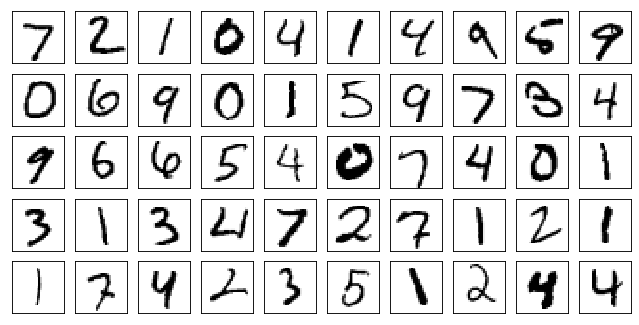

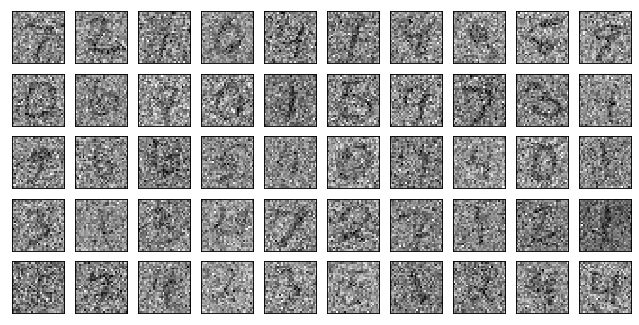

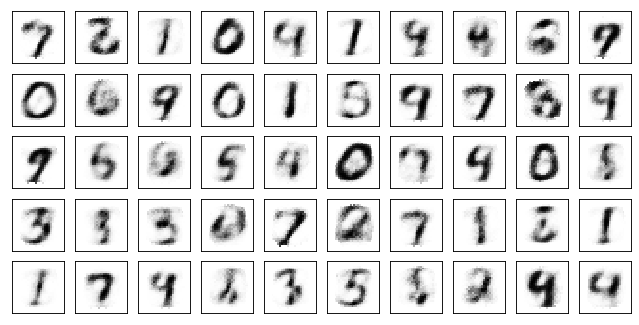

In [36]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noisy_data[:50], (5, 10))
plot_mnist(to_plot, (5, 10))